<a href="https://colab.research.google.com/github/jimmyzhang2003/SParCS/blob/master/COVID0413_Test_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [306]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns

In [307]:
import os
path_to_data = 'MSSM_COVID_FINAL/'
files = []
for file in os.listdir(path_to_data):
  if file.endswith('.txt'):
    files.append(file)

patient_df = pd.read_csv(path_to_data + files[0], sep="\t", 
                        error_bad_lines=False, encoding='latin1')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [308]:
"There are {} features in the patient dataset.".format(patient_df.shape[1])

'There are 73 features in the patient dataset.'

In [309]:
#drop variables irrelevant to COVID test outcome
patient_df_modified = patient_df.drop(columns=['ZIPCODE', 'MASKED_MRN', 'MASKED_ENCOUNTER_EPIC_CSN', 'FACILITY', 'ENC_ACUITY',
                                               'TOCILIZUMAB', 'DATE_OF_FIRST_TOCILIZUMAB', 'DECEASED_INDICATOR', 'TOCILIZUMAB',
                                                'DATE_OF_FIRST_TOCILIZUMAB', 'REMDESIVIR', 'DATE_OF_FIRST_REMDESIVIR',
                                               'SARILUMAB', 'DATE_OF_FIRST_SARILUMAB', 'HYDROXYCHLOROQUINE',
                                                'DATE_OF_FIRST_HYDROXYCHLOROQUINE', 'ANAKINRA',
                                                'DATE_OF_FIRST_ANAKINRA', 'AZITHROMYCIN', 'DATE_OF_FIRST_AZITHROMYCIN', 'ADMITTED', 'ICU'])
#also drop CANCER_DIAGNOSIS DESCRIPTION (inconsistent notation + mostly missing)
patient_df_modified = patient_df_modified.drop(columns = ['CANCER_DIAGNOSIS_DESCRIPTION']) 

In [310]:
#modifying the object values into categorical data 
cols_str = []
for col in patient_df_modified.columns: 
  if patient_df_modified[col].dtype == object or patient_df_modified[col].dtype == bool:
    cols_str.append(col)
  #print(patient_df_modified[col].dtype == bool)

for col in cols_str: 
  patient_df_modified[col] = pd.Categorical(patient_df_modified[col]).codes
  patient_df_modified[col] = patient_df_modified[col].replace(-1, np.nan) ##replace -1s with nan
print(cols_str)

['SEX', 'COVID_POS', 'RACE_SIMPLE', 'SMOKING_SIMPLE', 'COPD_ASTHMA']


In [311]:
"There are {} features remaining.".format(patient_df_modified.shape[1])

'There are 52 features remaining.'

In [312]:
### remove top 1% outliers for select vars (suspiciously high values) -> convert outliers to NAs first and remove later
select_vars = ['BMI', 'RESPIRATORY_RATE', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'DAYS_TO_DEATH_DISCHARGE', 'ALT_INITIAL', 'ALT_MAX', 
                'AST_INITIAL', 'AST_MAX', 'CRP_INITIAL', 'CRP_MAX', 'D-DIMER_INITIAL', 'D-DIMER_MAX', 'FERRITIN_INITIAL', 
                'FERRITIN_MAX', 'FIBRINOGEN_INITIAL', 'FIBRINOGEN_MAX', 'IL1B_INITIAL', 'IL1B_MAX', 'IL6_INITIAL', 'IL6_MAX',	
                'IL8_INITIAL', 'IL8_MAX',	'LDH_INITIAL', 'LDH_MAX', 'PROCALCITONIN_INITIAL',	'PROCALCITONIN_MAX',	'TNFa_INITIAL',	
                'TNFa_MAX',	'WBC_INITIAL', 'WBC_MAX']

patient_df_modified_no_outliers = patient_df_modified.copy()

for var in select_vars:
  q = patient_df_modified_no_outliers[var].quantile(0.99)
  for i in range(len(patient_df_modified_no_outliers[var])):
    if patient_df_modified_no_outliers[var][i] == np.nan or patient_df_modified_no_outliers[var][i] < q:
      continue
    else:
      patient_df_modified_no_outliers[var][i] = np.nan #replace outliers with NAs


patient_df_modified_no_outliers.describe(include='all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,AGE,SEX,COVID_POS,HTN,OBESITY,DIABETES,CHRONIC_KIDNEY_DISEASE,HIV_FLAG,CANCER_FLAG,BMI,TEMPERATURE,TEMP_MAX,HEART_RATE,RESPIRATORY_RATE,SYSTOLIC_BP,DIASTOLIC_BP,O2_SAT,O2SAT_MIN,RACE_SIMPLE,SMOKING_SIMPLE,COPD_ASTHMA,DAYS_TO_DEATH_DISCHARGE,ALT_INITIAL,ALT_MAX,AST_INITIAL,AST_MAX,BLOOD_CULTURE_INITIAL,BLOOD_CULTURE_MAX,COVID_Ab_INITIAL,COVID_Ab_MAX,CRP_INITIAL,CRP_MAX,D-DIMER_INITIAL,D-DIMER_MAX,FERRITIN_INITIAL,FERRITIN_MAX,FIBRINOGEN_INITIAL,FIBRINOGEN_MAX,IL1B_INITIAL,IL1B_MAX,IL6_INITIAL,IL6_MAX,IL8_INITIAL,IL8_MAX,LDH_INITIAL,LDH_MAX,PROCALCITONIN_INITIAL,PROCALCITONIN_MAX,TNFa_INITIAL,TNFa_MAX,WBC_INITIAL,WBC_MAX
count,12838.000000,12757.000000,12838.000000,12838.000000,12838.000000,12838.000000,12838.000000,12838.000000,12838.000000,7777.000000,9987.000000,9987.000000,9804.000000,9252.000000,9406.000000,9404.000000,9699.000000,9699.000000,11977.000000,9338.000000,12838.000000,7184.000000,5460.000000,5743.000000,5087.000000,5590.000000,2041.000000,2166.000000,554.000000,577.000000,1688.000000,1967.000000,2938.000000,3463.000000,3395.000000,3909.000000,1080.000000,1738.000000,299.000000,463.000000,1023.000000,1645.00000,333.000000,507.000000,3267.000000,3892.000000,3396.000000,3738.000000,334.000000,508.000000,6770.000000,6815.000000
mean,53.377006,0.502626,0.542997,0.208210,0.059121,0.146284,0.063016,0.017760,0.079062,28.092313,98.720537,99.761290,92.767238,19.203199,130.699979,75.874947,95.909578,91.175688,2.294147,1.591454,0.073376,2.751392,40.506044,63.211214,53.497936,83.211986,0.054875,0.091874,0.545126,0.549393,122.029568,152.083142,2.215589,3.715276,1215.362887,1696.522384,591.646296,642.418872,0.743478,0.825486,128.385924,248.12541,52.824925,58.822091,446.267218,528.600462,1.082032,2.151292,25.585928,25.422638,8.741775,10.965425
std,18.763625,0.500013,0.498167,0.406044,0.235861,0.353405,0.243001,0.132082,0.269846,6.345338,2.134668,1.914249,18.744661,3.390232,21.543308,13.031123,5.591693,12.941564,1.146089,0.650125,0.260763,4.084415,41.815076,83.821657,51.942434,117.940184,0.227792,0.288915,0.498409,0.497986,92.100219,109.106865,2.486805,4.309528,1674.457101,2474.124067,177.906946,204.471647,0.745354,0.954687,218.823672,499.61156,49.044694,58.596462,234.446290,318.211686,3.462116,6.814435,18.227937,14.862889,4.263749,6.007652
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.630000,35.000000,92.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,5.000000,5.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.270000,0.270000,0.040000,0.040000,4.000000,4.000000,43.000000,28.000000,0.000000,0.000000,1.000000,0.70000,1.000000,1.000000,97.000000,97.000000,0.000000,0.000000,2.000000,2.000000,0.200000,0.200000
25%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.720000,97.900000,98.400000,80.000000,18.000000,116.000000,68.000000,95.000000,90.000000,1.000000,1.000000,0.000000,0.000000,17.000000,20.000000,24.000000,29.000000,0.000000,0.000000,0.000000,0.000000,43.920000,56.650000,0.760000,0.960000,270.500000,328.000000,481.000000,509.000000,0.300000,0.300000,33.700000,36.10000,21.200000,23.750000,284.000000,316.000000,0.070000,0.080000,15.525000,15.900000,5.700000,6.600000
50%,54.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.250000,98.400000,99.300000,91.000000,18.000000,129.000000,76.000000,97.000000,95.000000,2.000000,2.000000,0.000000,1.000000,27.000000,35.000000,37.000000,48.000000,0.000000,0.000000,1.000000,1.000000,103.340000,135.790000,1.370000,1.960000,628.000000,818.000000,595.000000,637.000000,0.500000,0.500000,65.700000,76.00000,37.500000,40.600000,391.000000,447.000000,0.170000,0.240000,20.900000,21.450000,7.860000,9.500000
75%,68.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.600000,99.300000,101.000000,105.000000,20.000000,144.000000,84.000000,99.000000,98.000000,3.000000,2.000000,0.000000,4.000000,46.000000,6

In [314]:
patient_df_modified_no_outliers.isnull().sum() / patient_df_modified_no_outliers.shape[0] #check proportion of missing values

AGE                        0.000000
SEX                        0.006309
COVID_POS                  0.000000
HTN                        0.000000
OBESITY                    0.000000
DIABETES                   0.000000
CHRONIC_KIDNEY_DISEASE     0.000000
HIV_FLAG                   0.000000
CANCER_FLAG                0.000000
BMI                        0.394220
TEMPERATURE                0.222075
TEMP_MAX                   0.222075
HEART_RATE                 0.236330
RESPIRATORY_RATE           0.279327
SYSTOLIC_BP                0.267331
DIASTOLIC_BP               0.267487
O2_SAT                     0.244508
O2SAT_MIN                  0.244508
RACE_SIMPLE                0.067067
SMOKING_SIMPLE             0.272628
COPD_ASTHMA                0.000000
DAYS_TO_DEATH_DISCHARGE    0.440411
ALT_INITIAL                0.574700
ALT_MAX                    0.552656
AST_INITIAL                0.603754
AST_MAX                    0.564574
BLOOD_CULTURE_INITIAL      0.841019
BLOOD_CULTURE_MAX          0

In [315]:
#patient_df = patient_df.fillna(0)
## trying imputation instead of filling NAs with 0s?
from sklearn.impute import SimpleImputer

categorical_cols = ['SEX', 'RACE_SIMPLE', 'SMOKING_SIMPLE', 'COPD_ASTHMA']
num_cols = [col for col in patient_df_modified_no_outliers.columns if col not in categorical_cols]

#impute by mean for numerical columns
for col in num_cols:
  values = patient_df_modified_no_outliers[col].values.reshape(-1,1)
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
  transformed_values = imputer.fit_transform(values)
  patient_df_modified_no_outliers[col] = transformed_values

#impute by most frequent value for categorical columns
for col in categorical_cols:
  values = patient_df_modified_no_outliers[col].values.reshape(-1,1)
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  transformed_values = imputer.fit_transform(values)
  patient_df_modified_no_outliers[col] = transformed_values

In [335]:
patient_df_modified_no_outliers.isnull().sum() / patient_df_modified_no_outliers.shape[0] #no more missing values

AGE                        0.0
SEX                        0.0
COVID_POS                  0.0
HTN                        0.0
OBESITY                    0.0
DIABETES                   0.0
CHRONIC_KIDNEY_DISEASE     0.0
HIV_FLAG                   0.0
CANCER_FLAG                0.0
BMI                        0.0
TEMPERATURE                0.0
TEMP_MAX                   0.0
HEART_RATE                 0.0
RESPIRATORY_RATE           0.0
SYSTOLIC_BP                0.0
DIASTOLIC_BP               0.0
O2_SAT                     0.0
O2SAT_MIN                  0.0
RACE_SIMPLE                0.0
SMOKING_SIMPLE             0.0
COPD_ASTHMA                0.0
DAYS_TO_DEATH_DISCHARGE    0.0
ALT_INITIAL                0.0
ALT_MAX                    0.0
AST_INITIAL                0.0
AST_MAX                    0.0
BLOOD_CULTURE_INITIAL      0.0
BLOOD_CULTURE_MAX          0.0
COVID_Ab_INITIAL           0.0
COVID_Ab_MAX               0.0
CRP_INITIAL                0.0
CRP_MAX                    0.0
D-DIMER_

In [336]:
patient_df_modified_no_outliers.head()

,AGE,SEX,COVID_POS,HTN,OBESITY,DIABETES,CHRONIC_KIDNEY_DISEASE,HIV_FLAG,CANCER_FLAG,BMI,TEMPERATURE,TEMP_MAX,HEART_RATE,RESPIRATORY_RATE,SYSTOLIC_BP,DIASTOLIC_BP,O2_SAT,O2SAT_MIN,RACE_SIMPLE,SMOKING_SIMPLE,COPD_ASTHMA,DAYS_TO_DEATH_DISCHARGE,ALT_INITIAL,ALT_MAX,AST_INITIAL,AST_MAX,BLOOD_CULTURE_INITIAL,BLOOD_CULTURE_MAX,COVID_Ab_INITIAL,COVID_Ab_MAX,CRP_INITIAL,CRP_MAX,D-DIMER_INITIAL,D-DIMER_MAX,FERRITIN_INITIAL,FERRITIN_MAX,FIBRINOGEN_INITIAL,FIBRINOGEN_MAX,IL1B_INITIAL,IL1B_MAX,IL6_INITIAL,IL6_MAX,IL8_INITIAL,IL8_MAX,LDH_INITIAL,LDH_MAX,PROCALCITONIN_INITIAL,PROCALCITONIN_MAX,TNFa_INITIAL,TNFa_MAX,WBC_INITIAL,WBC_MAX
0,90.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,19.370000,97.500000,99.50000,70.000000,18.000000,118.000000,64.000000,92.000000,92.000000,3.0,2.0,0,2.000000,25.000000,29.000000,60.000000,73.000000,0.054875,0.091874,0.545126,0.549393,84.140000,99.400000,2.215589,3.715276,760.000000,760.000000,591.646296,642.418872,0.743478,0.825486,128.385924,248.12541,52.824925,58.822091,318.000000,358.000000,1.082032,2.151292,25.585928,25.422638,8.600000,8.600000
1,88.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.550000,101.100000,101.10000,109.000000,18.000000,122.000000,83.000000,90.000000,88.000000,1.0,2.0,0,8.000000,39.000000,39.000000,61.000000,92.000000,0.054875,0.091874,0.545126,0.549393,122.029568,283.220000,2.215589,3.715276,1215.362887,419.000000,591.646296,642.418872,0.743478,0.825486,128.385924,248.12541,52.824925,58.822091,446.267218,528.600462,1.082032,2.151292,25.585928,25.422638,14.000000,17.700000
2,65.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,20.420000,99.000000,103.10000,121.000000,18.000000,109.000000,78.000000,89.000000,76.000000,1.0,1.0,0,5.000000,20.000000,30.000000,19.000000,52.000000,0.000000,0.000000,0.545126,0.549393,122.029568,152.083142,2.720000,2.720000,4731.000000,4731.000000,899.000000,899.000000,0.743478,0.825486,128.385924,248.12541,52.824925,58.822091,474.000000,474.000000,4.660000,4.660000,25.585928,25.422638,17.600000,28.400000
3,73.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,28.092313,98.720537,99.76129,92.767238,19.203199,130.699979,75.874947,95.909578,91.175688,3.0,2.0,0,2.751392,40.506044,63.211214,53.497936,83.211986,0.054875,0.091874,0.545126,0.549393,122.029568,152.083142,2.215589,3.715276,1215.362887,1696.522384,591.646296,642.418872,0.743478,0.825486,128.385924,248.12541,52.824925,58.822091,446.267218,528.600462,1.082032,2.151292,25.585928,25.422638,8.741775,10.965425
4,86.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.100000,98.400000,98.40000,70.000000,18.000000,62.000000,25.000000,74.000000,38.000000,1.0,1.0,0,2.751392,40.506044,63.211214,53.497936,83.211986,0.054875,0.091874,0.545126,0.549393,122.029568,152.083142,2.215589,3.715276,1215.362887,1696.522384,468.000000,468.000000,0.743478,0.825486,128.385924,248.12541,52.824925,58.822091,1390.000000,1390.000000,4.140000,4.140000,25.585928,25.422638,16.300000,16.300000


In [337]:
!pip install eli5

In [338]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from  sklearn.base import BaseEstimator

import eli5
from eli5.sklearn import PermutationImportance
from IPython.core.display import display, HTML

from xgboost import XGBClassifier
from scipy import sparse

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

class TrainClassifier(BaseEstimator):
    
    def __init__(self, classifier=XGBClassifier(tree_hist='gpu_hist')):
        self.classifier = classifier 

    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 

    #1st method of feature extraction 
    def permutationImportances(self, model, dataset, X, y=None, display=False):
      model = model.fit(X, y)
      perm = PermutationImportance(model, random_state=42).fit(X, y)
      perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=X.columns.tolist()))
      if display: 
        display(eli5.show_weights(perm, feature_names=X.columns.tolist(), top=50))
      perm_df_filtered = perm_df[perm_df['weight'] >= 0]
      dataset_filtered = dataset[list(perm_df_filtered['feature'])]
      return dataset_filtered

    #2nd method of feature extraction 
    def bioMarkerFilter(self, dataset):
      biomarkers = ['SMOKING_SIMPLE', 'COPD_ASTHMA', 'DIABETES', 'CHRONIC_KIDNEY_DISEASE', 'HIV_FLAG',
              'BMI', 'HTN', 'TEMPERATURE', 'HEART_RATE', 'RESPIRATORY_RATE',
              'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT']
      biomarkers = biomarkers + [col for col in dataset.columns if col.endswith('_INITIAL')]
      dataset_modified_biomarkers = dataset[biomarkers]
      return dataset_modified_biomarkers 
      
    def predict(self, X, y=None):
        self.classifier.predict(X)

    def score(self, X, y=None):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        accuracy = accuracy_score(y_important_test, predictions)
        return ("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    def displayPredictionMatrix(self, X_test, y_test):
      unique_labels = [0, 1]
      testing_predictions = self.classifier.predict(X_test)
      seed = np.random.seed(0)
      matrix = confusion_matrix(y_test, testing_predictions, labels=unique_labels)
      sns.heatmap(matrix, annot=True, xticklabels=unique_labels, yticklabels=unique_labels)
      plt.ylabel('Actual/True Label')
      plt.xlabel('Predicted Label')
      plt.title('Confusion Matrix for Predicted Labeling')

In [340]:
import pickle

patient_df_modified_features = patient_df_modified_no_outliers.columns
patient_df_modified_features = [feature for feature in patient_df_modified_features if feature != "COVID_POS"]
target = patient_df_modified_no_outliers['COVID_POS']

X_train, X_test, y_train, y_test = train_test_split(patient_df_modified_no_outliers[patient_df_modified_features], 
                                                        target, test_size=0.3, random_state=np.random.seed(0))
    
pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                 ('classifier', RandomForestClassifier())])
               
params =  {'classifier': [RandomForestClassifier()], 
         'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
         'classifier__max_features': ['auto', 'sqrt'],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__n_estimators': [int(x) for x in np.linspace(start=200, stop=300, num=10)], 
         'classifier__max_depth': [int(x) for x in np.linspace(start=10, stop=50, num=10)],
         'classifier__bootstrap': [True, False]}

rscv = RandomizedSearchCV(pipe, params, n_iter=100, verbose=2, cv=5, random_state=np.random.seed(0), n_jobs=-1)
rscv.fit(X_train, y_train)
random_forest_best = rscv.best_params_['classifier']
filename = 'random_forest_best.sav'
rfcb_saved = pickle.dump(random_forest_best, open(filename, 'wb'))
rfcb_loaded = pickle.load(open(filename, 'rb'))
rfcb_model = rfcb_loaded.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 24.0min finished


In [341]:
tr = TrainClassifier()
permutation_dataset = tr.permutationImportances(rfcb_model, patient_df_modified_no_outliers, X_test, y_test)

X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(permutation_dataset, 
                                                                                            target, test_size=0.3, random_state=42)
tr.fit(X_important_train, y_important_train)
tr.score(X_important_test)

'Accuracy: 74.25%'

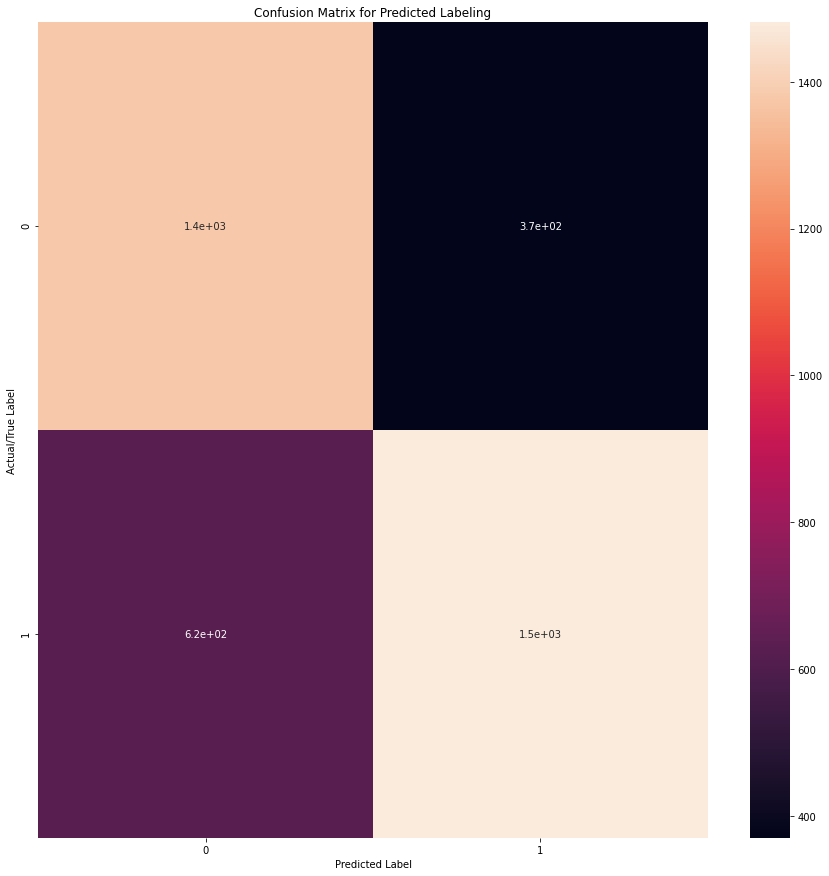

In [342]:
plt.figure(figsize=(15, 15))
tr.displayPredictionMatrix(X_important_test, y_important_test)

In [343]:
biomarker_dataset = tr.bioMarkerFilter(patient_df_modified_no_outliers)

X_train, X_test, y_train, y_test = train_test_split(biomarker_dataset, 
                                                        target, test_size=0.3, random_state=np.random.seed(0))

tr.fit(X_train, y_train)
tr.score(X_test)

'Accuracy: 49.51%'